In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [ ]:
from state_space_setup import *
from policy_df_generator import *


# load the necessary data created by the optimisation script
cost_matrix = np.load("cost_matrix.npy")
policy = pd.read_csv('policy.csv')
value_iteration_values = np.load("values.npy")

# format the State column in the policy dataframe
policy['State'] = policy['State'].apply(lambda x: tuple(map(int, x.strip('()').split(','))))

# display the policy to dataframe to verify that the loading was successful
display(policy)

# extract the maximum number of parts from the policy dataframe
maximum_parts = policy['State'].apply(lambda x: x[0]).max()
print("Maximum number of parts in the inventory:", maximum_parts)

# generate the state space
state_space = get_state_space(maximum_parts)
state_tuples = list(map(tuple, state_space))

,State,Order_size
0,"(0, 0)",34
1,"(0, 1)",33
2,"(0, 2)",32
3,"(0, 3)",31
4,"(0, 4)",30
...,...,...
898,"(39, 1)",0
899,"(39, 2)",0
900,"(40, 0)",0
901,"(40, 1)",0


Maximum number of parts in the inventory: 41


In [97]:
def generate_demand(num_periods=1000, lambda_=2, p=0.9):
    """
    Input: num_periods (int): Number of periods for which to generate demand.
           lambda_ (float): Mean number of parts that break per week.
           p (float): Probability of the order arriving in a given week.
    Output: demand (np.ndarray): Array of generated demand values.
    
    This function generates demand values for a given number of periods using a
    Poisson distribution with the specified mean (lambda_).
    """
    demand = np.random.poisson(lam=lambda_, size=num_periods)
    arrivals = np.random.binomial(1, p, size=num_periods)

    return np.column_stack((demand, arrivals))

In [98]:
discount_factor = 0.995


# simulation function
def apply_policy(initial_state, policy_df, demands):
    """
    Input: initial_state (tuple): Initial state of the inventory.
           policy_df (pd.DataFrame): A two-column dataframe representing the chosen policy.
           demands (np.array): Pregernerated demand values for the simulation.
    Output: SAC_df (pd.DataFrame): Dataframe containing the states, chosen actions and the
                                   costs associated with (old state, action, new state).

    This function applies policy and extracts the states of the inventory under a pre-sampled 
    demand. At each stage the algorithm picks an action according to the provided policy 
    (policy_df), obtains a new state according to the pre-sampled demand and chosen action,
    and computes the associated cost using the cost matrix - both created in the optimisation script.
    """
    global maximum_parts, cost_matrix

    # obtain the number of periods and convert the policy dataframe to a dictionary
    num_periods = len(demands)
    policy_dict = dict(zip(policy_df["State"], policy_df["Order_size"]))

    # storing the states, actions and costs as numpy arrays
    states = np.zeros((num_periods + 1, 2), dtype=int)
    actions = np.zeros(num_periods + 1, dtype=int)
    costs = np.zeros(num_periods + 1, dtype=float)

    states[0] = initial_state
    actions[0] = policy_dict[tuple(states[0])]
    costs[0] = 0

    for i in range(num_periods):
        # get the current state action
        current_state = states[i]
        current_idx = get_index(current_state[0], current_state[1], maximum_parts)
        action = actions[i]

        new_IL = max(0, current_state[0] - demands[i, 0]) + (current_state[1] + action) * demands[i, 1]
        new_OP = (current_state[1] + action) * (1 - demands[i, 1])
        
        # calculate and store the cost of the simulated scenario
        new_idx = get_index(new_IL, new_OP, maximum_parts)
        cost = cost_matrix[current_idx, new_idx, action]
        costs[i+1] = cost

        # store the new state and the corresponding action
        states[i+1] = (new_IL, new_OP)
        actions[i+1] = policy_dict[(new_IL, new_OP)]

    SAC_df = pd.DataFrame({
        "States" : [tuple(s) for s in states],
        "Actions" : actions,
        "Costs" : costs
    })
    
    return SAC_df

In [99]:
def total_cost(simulated_data):
    """
    Input: simulated_data (pd.DataFrame): A three-column dataframe containing the simulated
                                          states, chosen actions and associated costs.
           plots (bool): Variable indicating if plots should be produced
           discount_factor (float): Chosen discount factor weighting the future costs.
    Output: total_cost (float): Total discounted cost of the initial state over the 
                                simulated period.

    This function takes the simulated output in the form of a dataframe. If the plots parameter
    is set to True, the function presents the trend in the inventory level and position as 
    line plots as well as cumulative discounted cost.
    """
    global discount_factor
    
    # calculate the total discounted cost
    factor_sequence = discount_factor ** np.arange(len(simulated_data["Costs"]))
    discounted_cost = np.sum(factor_sequence * np.array(simulated_data["Costs"]))
        
    return discounted_cost

In [100]:
def plot_simulation(simulated_data, which_plots=[True, False, False, False]):
    """
    Input: simulated_data (pd.DataFrame): A three-column dataframe containing the simulated
                                          states, chosen actions and associated costs.
           which_plots (bool tuple): A tuple of booleans indicating which plots to generate:
                                        - (Inventory Level, Inventory Position, Cumulative Cost, Actions)
    Output: None

    This function plots the inventory levels, positions and cumulative discounted cost
    from the simulated data.
    """
    global discount_factor
    
    # calculate the cumulative discounted cost
    factor_sequence = discount_factor ** np.arange(len(simulated_data["Costs"]))
    cum_discounted_cost = np.cumsum(factor_sequence * np.array(simulated_data["Costs"]))

    # setting colours 
    colours = ['#A499F4', '#F1977F']  # Lavander and Coral
    col_indices = (np.cumsum(np.array(which_plots)) + 1) % 2  # to alternate colours based on which plots are selected
    
    # prepare the data for plotting
    inventory_levels = [state[0] for state in simulated_data["States"]]
    inventory_positions = [state[0] + state[1] for state in simulated_data["States"]]
    actions = simulated_data["Actions"].values

    if which_plots[0]:
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(len(inventory_levels)), inventory_levels, 
                 label='Inventory Level', color=colours[col_indices[0]], linewidth=1.5)
        plt.ylabel('Inventory Level')
        plt.xlabel('Week')
        plt.title('Inventory Level Over Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    if which_plots[1]:
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(len(inventory_positions)), inventory_positions, 
                 label='Inventory Position', color=colours[col_indices[1]], linewidth=1.5)
        plt.ylabel('Inventory Position')
        plt.xlabel('Week')
        plt.title('Inventory Position Over Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    if which_plots[2]:
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(len(cum_discounted_cost)), cum_discounted_cost, 
                 label='Cumulative Discounted Cost', color=colours[col_indices[2]], linewidth=1.5)
        plt.ylabel('Cumulative Cost')
        plt.xlabel('Week')
        plt.title('Cumulative Discounted Cost Over Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    if which_plots[3]:
        plt.figure(figsize=(10, 6))
        plt.bar(np.arange(len(actions)), actions, 
                label='Actions Taken', color=colours[3 % len(colours)])
        plt.ylabel('Action Size')
        plt.xlabel('Week')
        plt.title('Actions Taken Over Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return None

In [128]:
np.random.seed(42)
state = (7, 11)
size = 2000
state_idx = get_index(state[0], state[1], maximum_parts)
sampled_costs_optimal = np.zeros(size)
sampled_costs_approx = np.zeros(size)

d = generate_demand(4000, 2, 0.9)
policy2 = generate_sS_policy(11, 21, maximum_parts)

for i in range(size):
    demand = generate_demand(4000, 2, 0.9)
    sampled_costs_optimal[i] = total_cost(apply_policy(state, policy, demand))
    sampled_costs_approx[i] = total_cost(apply_policy(state, policy2, demand))
    if (i + 1) % 100 == 0:
        print(f"Sample {i + 1}/2000: Optimal policy scst = {sampled_costs_optimal[i]},\n \
             Approximate, purely (s,S) policy cost = {sampled_costs_approx[i]}")


Sample 100/2000: Optimal policy scst = 46247.16433653444,
              Approximate, purely (s,S) policy cost = 50101.66798949197
Sample 200/2000: Optimal policy scst = 45192.95285922047,
              Approximate, purely (s,S) policy cost = 47624.12449283789
Sample 300/2000: Optimal policy scst = 46980.23942568922,
              Approximate, purely (s,S) policy cost = 47567.0022463919
Sample 400/2000: Optimal policy scst = 46004.40765302281,
              Approximate, purely (s,S) policy cost = 48339.98430561259
Sample 500/2000: Optimal policy scst = 47127.48672959849,
              Approximate, purely (s,S) policy cost = 49358.53992350556
Sample 600/2000: Optimal policy scst = 48484.94395746294,
              Approximate, purely (s,S) policy cost = 50888.376558894866
Sample 700/2000: Optimal policy scst = 45810.60765190449,
              Approximate, purely (s,S) policy cost = 47775.28055299136
Sample 800/2000: Optimal policy scst = 48146.45583323581,
              Approximate, purel

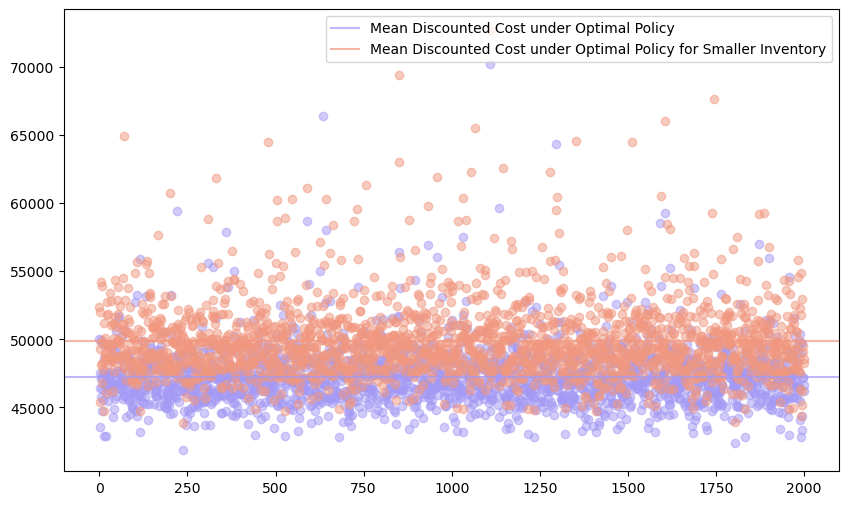

The mean of the sampled costs under optimal policy: 47254.93566091214
The mean of the sampled costs under optimal policy for smaller inventory: 49853.20455661105
The differences between the two as a percentage of the true value obtained via value iteration: 5.457573261318629 %
(Value obtained from value iteration 47608.502374389165 )


In [129]:
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(sampled_costs_optimal)), sampled_costs_optimal, color='#A499F4', alpha=0.5)
plt.scatter(np.arange(len(sampled_costs_optimal)), sampled_costs_approx, color='#F1977F', alpha=0.5)
plt.axhline(np.mean(sampled_costs_optimal), color='#A499F4', linestyle='-', label='Mean Discounted Cost under Optimal Policy', alpha=0.7)
plt.axhline(np.mean(sampled_costs_approx), color='#F1977F', linestyle='-', label='Mean Discounted Cost under Optimal Policy for Smaller Inventory', alpha=0.7)
plt.legend()
plt.savefig("plots/sampled_costs_comparison.pdf", format="pdf", bbox_inches='tight')
plt.show()

print("The mean of the sampled costs under optimal policy:", np.mean(sampled_costs_optimal))
print("The mean of the sampled costs under optimal policy for smaller inventory:", np.mean(sampled_costs_approx))
print("The differences between the two as a percentage of the true value obtained via value iteration:",
      (np.mean(sampled_costs_approx) - np.mean(sampled_costs_optimal)) / value_iteration_values[state_idx] * 100, "%")
print("(Value obtained from value iteration", value_iteration_values[state_idx], ")")

In [108]:
sample_size = 400
sample_averages = np.zeros(len(state_tuples))

for i, state in enumerate(state_tuples):
    cost_samples = np.zeros(sample_size)
    for j in range(sample_size):
        demand = generate_demand(4000, 2, 0.9)
        cost_samples[j] = total_cost(apply_policy(state, policy, demand))
    sample_averages[i] = np.mean(cost_samples)
    if (i + 1) % 10 == 0:
        print(f"Finished sampling for state {i + 1}/{len(state_tuples)}")

Finished sampling for state 10/903
Finished sampling for state 20/903
Finished sampling for state 30/903
Finished sampling for state 40/903
Finished sampling for state 50/903
Finished sampling for state 60/903
Finished sampling for state 70/903
Finished sampling for state 80/903
Finished sampling for state 90/903
Finished sampling for state 100/903
Finished sampling for state 110/903
Finished sampling for state 120/903
Finished sampling for state 130/903
Finished sampling for state 140/903
Finished sampling for state 150/903
Finished sampling for state 160/903
Finished sampling for state 170/903
Finished sampling for state 180/903
Finished sampling for state 190/903
Finished sampling for state 200/903
Finished sampling for state 210/903
Finished sampling for state 220/903
Finished sampling for state 230/903
Finished sampling for state 240/903
Finished sampling for state 250/903
Finished sampling for state 260/903
Finished sampling for state 270/903
Finished sampling for state 280/903
F

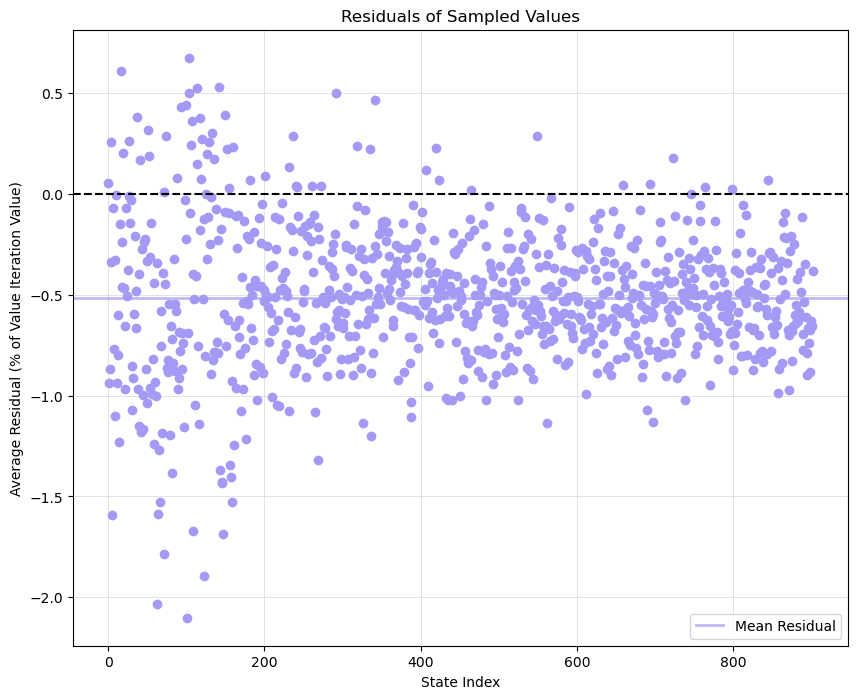

In [119]:
residuals = (sample_averages - value_iteration_values)/ value_iteration_values * 100

plt.figure(figsize=(10, 8))
plt.scatter(np.arange(903), residuals, color='#A499F4')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(np.mean(residuals), color='#A499F4', linestyle='-', label='Mean Residual', alpha=0.7, linewidth=2)
plt.title("Residuals of Sampled Values")
plt.xlabel("State Index")
plt.ylabel("Average Residual (% of Value Iteration Value)")
plt.grid(True, which="both", linestyle="-", linewidth=0.5, alpha=0.5)
plt.legend(loc='lower right')
plt.savefig("plots/residuals_sampled_values.pdf", format="pdf", bbox_inches='tight') 
plt.show()   